In [1]:
import argparse
import os
import time
from pathlib import Path

import numpy as np
import pytorch_lightning as pl
import torch
import wandb
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms
import models.arch as models

import timm
from torchvision.datasets import CIFAR10, CIFAR100
from tqdm import tqdm

## 
# plot.py
import functools

import matplotlib
import matplotlib.pyplot as plt
import datetime 

import scipy.stats
from sklearn.metrics import auc, roc_curve

from collections import Counter

import dataset.cifar10 as dataset
import torch.utils.data as data


##
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps")

In [2]:
# for vit_large_patch16_224_cifar10, CIFAR-10
'''
lr=0.02
epochs=25
n_shadows = 64
shadow_id = -1 
model = "efficientnet_b7"
dataset = "cifar100"
pkeep = 0.5
savedir = f"exp/{model}_{dataset}"
debug = True
'''

# for vgg19, CIFAR-10
lr = 0.05
epochs = 25
n_shadows = 64
shadow_id = -1 
arch = "efficientnet_b7"
dataset_ = "cifar10"
pkeep = 0.5
savedir = f"exp/{arch}_{dataset_}"
debug = True

In [3]:
seed = 1583745484

In [4]:
def calculate_mean_std(dataloader):
    """
    Calculate per-channel mean and standard deviation from a DataLoader.
    """
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_samples = 0

    dataloader_iter = iter(dataloader)

    for batch_idx in range(len(dataloader)):
        images, _ = next(dataloader_iter)
        
        # Undo ToTensor scaling if normalization has already been applied
        # images = images * 255.0 if torch.max(images) <= 1.0 else images
        # print(images.shape)
        
        batch_samples = images.size(0)  # Batch size

        # Accumulate mean and std for the batch
        mean += images.mean(dim=[0, 2, 3]) * batch_samples
        std += images.std(dim=[0, 2, 3]) * batch_samples
        total_samples += batch_samples

    # Compute the overall mean and std
    mean /= total_samples
    std /= total_samples

    return mean, std


@torch.no_grad()
def get_acc(model, dl):
    acc = []
    for x, y in dl:
        x, y = x.to(DEVICE), y.to(DEVICE)
        acc.append(torch.argmax(model(x), dim=1) == y)
    acc = torch.cat(acc)
    acc = torch.sum(acc) / len(acc)

    return acc.item()

# @@@@@@@ imported data exploration @@@@@@@

In [6]:
classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

datadir = Path().home() / "dataset"

raw_train_ds = CIFAR10(root=datadir, train=True, download=True, transform=None)
raw_test_ds = CIFAR10(root=datadir, train=False, download=True, transform=None)

train_labels = [raw_train_ds[i][1] for i in range(len(raw_train_ds))]
test_labels = [raw_test_ds[i][1] for i in range(len(raw_test_ds))]
train_class_counts = Counter(train_labels)
test_class_counts = Counter(test_labels)

print("Train 클래스 분포:", {classes[k]: v for k, v in train_class_counts.items()})
print("Test 클래스 분포:", {classes[k]: v for k, v in test_class_counts.items()})

Files already downloaded and verified
Files already downloaded and verified
Train 클래스 분포: {'frog': 5000, 'truck': 5000, 'deer': 5000, 'automobile': 5000, 'bird': 5000, 'horse': 5000, 'ship': 5000, 'cat': 5000, 'dog': 5000, 'airplane': 5000}
Test 클래스 분포: {'cat': 1000, 'ship': 1000, 'airplane': 1000, 'frog': 1000, 'automobile': 1000, 'truck': 1000, 'dog': 1000, 'horse': 1000, 'deer': 1000, 'bird': 1000}


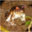

In [7]:
raw_train_ds[0][0]

In [8]:
type(raw_train_ds[0][0])

PIL.Image.Image

In [9]:
raw_train_ds[0][1]

6

In [13]:
'''
w/o normalization 
Train 데이터셋 픽셀 평균 (채널별): [125.30691805 122.95039414 113.86538318]
Train 데이터셋 픽셀 표준 편차 (채널별): [62.99321928 62.08870764 66.70489964]

with normalization
Train 데이터셋 픽셀 평균 (채널별): [0.49139968 0.48215841 0.44653091]
Train 데이터셋 픽셀 표준 편차 (채널별): [0.24703223 0.24348513 0.26158784]
'''

train_data = np.stack([raw_train_ds[i][0] for i in range(len(raw_train_ds))], axis=0)
train_data = train_data / 255.0  # [0, 255] -> [0, 1] 정규화

mean_per_channel = train_data.mean(axis=(0, 1, 2))
std_per_channel = train_data.std(axis=(0, 1, 2))

print("Train 데이터셋 픽셀 평균 (채널별):", mean_per_channel)
print("Train 데이터셋 픽셀 표준 편차 (채널별):", std_per_channel)

Train 데이터셋 픽셀 평균 (채널별): [0.49139968 0.48215841 0.44653091]
Train 데이터셋 픽셀 표준 편차 (채널별): [0.24703223 0.24348513 0.26158784]


In [14]:
train_data.shape

(50000, 32, 32, 3)

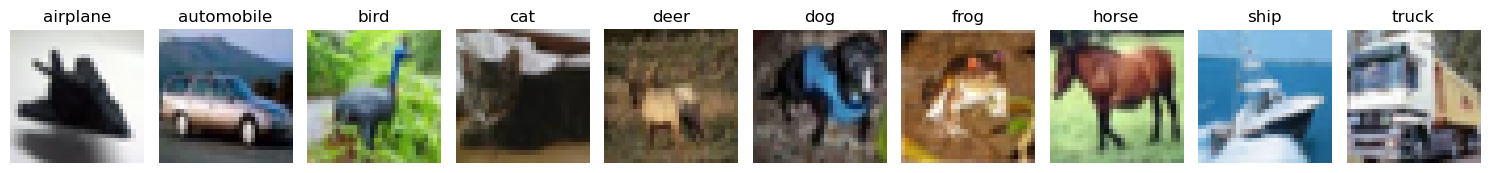

In [24]:
# 클래스별 이미지 시각화
fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i, class_idx in enumerate(range(10)):
    class_samples = [raw_train_ds[idx][0] for idx, label in enumerate(train_labels) if label == class_idx]
    axes[i].imshow(class_samples[0])
    axes[i].set_title(classes[class_idx])
    axes[i].axis("off")
plt.tight_layout()
plt.show()

# @@@@@@@ LiRA data exploration @@@@@@@

In [34]:
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]),
    ]
)
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]),
    ]
)

torch.manual_seed(seed)
datadir = Path().home() / "dataset"

if dataset_ == "cifar10":
    print("import cifar10...")
    lira_train_ds = CIFAR10(root=datadir, train=True, download=True, transform=train_transform)
    lira_test_ds = CIFAR10(root=datadir, train=False, download=True, transform=test_transform)
elif dataset_ == "cifar100":
    print("import cifar100...")
    lira_train_ds = CIFAR100(root=datadir, train=True, download=True, transform=train_transform)
    lira_test_ds = CIFAR100(root=datadir, train=False, download=True, transform=test_transform)
else:
    raise ValueError("undefined dataset")

# train_ds, eval_ds = random_split(train_ds, [0.8, 0.2])

# train_labels = [lira_train_ds[i][1] for i in range(len(lira_train_ds))]
# test_labels = [lira_test_ds[i][1] for i in range(len(lira_test_ds))]
# train_class_counts = Counter(train_labels)
# test_class_counts = Counter(test_labels)

# print("Train 클래스 분포:", {classes[k]: v for k, v in train_class_counts.items()})
# print("Test 클래스 분포:", {classes[k]: v for k, v in test_class_counts.items()})

import cifar10...
Files already downloaded and verified
Files already downloaded and verified


In [35]:
lira_train_ds[0][0].shape

torch.Size([3, 32, 32])

In [36]:
train_data = np.stack([lira_train_ds[i][0] for i in range(len(lira_train_ds))], axis=0)

In [37]:
train_data.shape

(50000, 3, 32, 32)

In [38]:
train_data = np.stack([lira_train_ds[i][0] for i in range(len(lira_train_ds))], axis=0)
# train_data = train_data / 255.0  # [0, 255] -> [0, 1] 정규화

mean_per_channel = train_data.mean(axis=(0, 2, 3)) 
std_per_channel = train_data.std(axis=(0, 2, 3))  

print("Train 데이터셋 픽셀 평균 (채널별):", mean_per_channel)
print("Train 데이터셋 픽셀 표준 편차 (채널별):", std_per_channel)

Train 데이터셋 픽셀 평균 (채널별): [-0.26980224 -0.27595136 -0.23877054]
Train 데이터셋 픽셀 표준 편차 (채널별): [1.1450162 1.141004  1.0874275]


In [39]:
lira_trainloader = data.DataLoader(lira_train_ds, batch_size=64, shuffle=True, num_workers=2, drop_last=True)

In [40]:
mean, std = calculate_mean_std(lira_trainloader)
print(f"Dataset Mean: {mean}")
print(f"Dataset Std: {std}")

Dataset Mean: tensor([-0.2708, -0.2768, -0.2396])
Dataset Std: tensor([1.1435, 1.1396, 1.0851])


# @@@@@@@ MixMatch data exploration @@@@@@@

In [36]:
print(f'==> Preparing cifar10')
transform_train = transforms.Compose([
    dataset.RandomPadandCrop(32),
    dataset.RandomFlip(),
    dataset.ToTensor(),
])

transform_val = transforms.Compose([
    dataset.ToTensor(),
])
datadir = Path().home() / "dataset"

batch_size=64

train_labeled_set, train_unlabeled_set, val_set, test_set = dataset.get_cifar10(datadir, 40000, transform_train=transform_train, transform_val=transform_val)
labeled_trainloader = data.DataLoader(train_labeled_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
unlabeled_trainloader = data.DataLoader(train_unlabeled_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

==> Preparing cifar10
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
#Labeled: 40000 #Unlabeled: 5000 #Val: 5000


In [37]:
train_labeled_set

Dataset CIFAR10_labeled
    Number of datapoints: 40000
    Root location: /home/dsanyal7/dataset
    Split: Train
    StandardTransform
Transform: Compose(
           )

In [38]:
train_unlabeled_set

Dataset CIFAR10_unlabeled
    Number of datapoints: 5000
    Root location: /home/dsanyal7/dataset
    Split: Train
    StandardTransform
Transform: <dataset.cifar10.TransformTwice object at 0x7fce14c6a130>

In [39]:
train_labeled_set.data.shape

(40000, 3, 32, 32)

In [40]:
# train_labeled_set.data

In [41]:
train_labeled_set.targets.shape

(40000,)

In [42]:
# train_labeled_set.targets

In [43]:
## Compute mean and std for the raw dataset
#
# Dataset Mean: tensor([-1.6901e-04,  3.4511e-05,  6.4206e-04])
# Dataset Std: tensor([0.9966, 0.9978, 0.9977])
#
# mean, std = calculate_mean_std(labeled_trainloader)
# print(f"Dataset Mean: {mean}")
# print(f"Dataset Std: {std}")

In [44]:
test_set

Dataset CIFAR10_labeled
    Number of datapoints: 10000
    Root location: /home/dsanyal7/dataset
    Split: Test
    StandardTransform
Transform: Compose(
           )

# let's start training! (set train_dl with a target dataset)

In [45]:
np.random.seed(seed)

In [46]:
## TODO: switch to target dataset

## LiRA
# train_ds = lira_train_ds
# test_ds = lira_test_ds

## MixMatch
train_ds = train_labeled_set
test_ds = test_set

In [47]:
# train_ds = torch.utils.data.Subset(train_ds, keep)
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=4)

In [48]:
len(train_ds) # 50%(pkeep) of training dataset

20000

In [49]:
m = models.network(arch, pretrained=False, n_classes=10)
m = m.to(DEVICE)
# print(m)

# For efficient fine-tune, freeze some intermediate layers within model
# m = freeze_interdemidate_layers(m, model)

arch: efficientnet_b7, pretrained: False, n_classes: 10


In [50]:
optim = torch.optim.SGD(m.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=epochs)

In [51]:
# wandb.init(project="lira", mode="disabled" if debug else "online")
# wandb.config.update(args)

for epoch in range(epochs):
    m.train()
    loss_total = 0
    pbar = tqdm(train_dl)
    for itr, (x, y) in enumerate(pbar):
        x, y = x.to(DEVICE), y.to(DEVICE)

        outputs = m(x)
        loss = F.cross_entropy(outputs, y)
        loss_total += loss
        
        pbar.set_postfix_str(f"loss: {loss:.2f}")
        optim.zero_grad()
        loss.backward()
        optim.step()
    sched.step()

    test_acc = get_acc(m, test_dl)
    print(f"[Epoch {epoch}] Test Accuracy: {test_acc:.4f}")
    # wandb.log({"loss": loss_total / len(train_dl)})

print(f"[test] acc_test: {get_acc(m, test_dl):.4f}")
# wandb.log({"acc_test": get_acc(m, test_dl)})

savedir_victim = os.path.join(savedir, "victim")
# os.makedirs(savedir_victim, exist_ok=True)
# np.save(savedir_victim + "/keep.npy", keep_bool)
# torch.save(m.state_dict(), savedir_victim + "/model.pt")
# print('save done')

100%|██████████| 157/157 [00:15<00:00, 10.09it/s, loss: 2.92]


[Epoch 0] Test Accuracy: 0.1050


 80%|████████  | 126/157 [00:12<00:03,  9.91it/s, loss: 2.72]


KeyboardInterrupt: 